In [95]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim


# Importación del CSV

In [96]:
datapath = 'data'
df = pd.read_csv(os.path.join(datapath, 'uber_fares.csv'))
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199994,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199995,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199996,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199997,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [97]:
#df.dtypes

# Preprocesamiento de los datos

In [98]:
# Sustituimos las fechas por timestamps
# df['pickup_timestamp'] = df['pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').timestamp())
df['pickup_timestamp'] = df['pickup_datetime'].apply(lambda x: pd.Timestamp(x))
df['pickup_day'] = df['pickup_timestamp'].apply(lambda x: x.day)
df.drop('pickup_datetime', axis=1)
df.drop('pickup_timestamp', axis=1)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,7
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,17
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,24
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,26
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,28
...,...,...,...,...,...,...,...,...
199994,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1,28
199995,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1,14
199996,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2,29
199997,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1,20


### Cálculo de la distancia mediante el semiverseno
El semiverseno se utiliza para calcular la distancia en la superfície de una esfera dadas las coordenadas de los puntos en la misma.

Fórmula del semiverseno utilizada: 

$$ semiversin\left({d\over R}\right) = semiversin(φ_1 - φ_2) + cos(φ_1) cos(φ_2) semiversin(\small \Delta λ) $$

Donde:
* $d$ es la distancia entre dos los dos puntos
* $R$ es el radio de la esfera
* $φ_1$ es la latitud del punto 1
* $φ_2$ es la latitud del punto 2
* $\small \Delta λ$ es la la diferencia de longitudes de los puntos

In [99]:
# Función que calcula la distancia en la tierra entre dos pares de coordenadas usando el semiverseno, devuelve la distancia en metros
def coordsToDistance(long1: float, lat1: float, long2: float, lat2: float):
    # Radio de la tierra aprox
    R = 6367000
    # Grados a radianes
    degToRad = math.pi / 180

    distLong = (long2 - long1) * degToRad
    distLat = (lat1 - lat2) * degToRad
    
    a = (math.sin(distLat / 2) ** 2) + (math.cos(lat1 * degToRad) * math.cos(lat2 * degToRad) * (math.sin(distLong / 2) ** 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d


In [100]:
# Reemplazamos las columnas de las coordenaas con la distancia
coords:np.ndarray = df.iloc[:, 2:6].to_numpy()
distances = np.apply_along_axis(lambda x: coordsToDistance(x[0], x[1], x[2], x[3]), 1, coords)
df.insert(2, 'distance_run', pd.Series(distances))
# df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1 )
df.head()



,fare_amount,pickup_datetime,distance_run,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_timestamp,pickup_day
0,7.5,2015-05-07 19:52:06 UTC,1682.265887,-73.999817,40.738354,-73.999512,40.723217,1,2015-05-07 19:52:06+00:00,7
1,7.7,2009-07-17 20:04:56 UTC,2456.046898,-73.994355,40.728225,-73.994710,40.750325,1,2009-07-17 20:04:56+00:00,17
2,12.9,2009-08-24 21:45:00 UTC,5033.215126,-74.005043,40.740770,-73.962565,40.772647,1,2009-08-24 21:45:00+00:00,24
3,5.3,2009-06-26 08:22:21 UTC,1660.640179,-73.976124,40.790844,-73.965316,40.803349,3,2009-06-26 08:22:21+00:00,26
4,16.0,2014-08-28 17:47:00 UTC,4472.640074,-73.925023,40.744085,-73.973082,40.761247,5,2014-08-28 17:47:00+00:00,28


### Limpieza de datos
Datos a eliminar:
* Viajes con mas de 6 pasajeros
* Viajes muy cortos o muy largos
* Viajes precios desorbitados
* etc...

In [101]:
df.drop(df[df['distance_run'] > 60000].index, inplace=True)
df.drop(df[df['distance_run'] < 10].index, inplace=True)
df.drop(df[df['fare_amount'] > 100].index, inplace=True)
df.drop(df[df['fare_amount'] < 1].index, inplace=True)


In [117]:
uberCountries = pd.read_csv('data/uber_countries.csv')
uclist = uberCountries[uberCountries['availability'] != 'No']['country'].to_numpy()
# df[getCountry(df['pickup_latitude'], df['pickup_longitude']) in uclist and getCountry(df['dropoff_latitude'], df['dropoff_longitude']) in uclist]
df[['pickup_latitude', 'pickup_longitude']].apply(lambda x: print(x), axis=1)


0         40.738354
1         40.728225
2         40.740770
3         40.790844
4         40.744085
            ...    
199994    40.739367
199995    40.736837
199996    40.756487
199997    40.725452
199998    40.720077
Name: pickup_latitude, Length: 193321, dtype: float64
0        -73.999817
1        -73.994355
2        -74.005043
3        -73.976124
4        -73.925023
            ...    
199994   -73.987042
199995   -73.984722
199996   -73.986017
199997   -73.997124
199998   -73.984395
Name: pickup_longitude, Length: 193321, dtype: float64


pickup_latitude     None
pickup_longitude    None
dtype: object

# Creación de los conjuntos de test y train

In [ ]:
x = df.iloc[:, 1:]
y = pd.DataFrame(df.iloc[:, 0])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)

#Mostrar las caracerísticas de los arrays
print('Conjuntos de datos:')
print('xTrain: ' + str(xTrain.shape))
print('xTest: ' + str(xTest.shape))
print('yTrain: ' + str(yTrain.shape))
print('yTest: ' + str(yTest.shape))

Conjuntos de datos:
xTrain: (154656, 5)
xTest: (38665, 5)
yTrain: (154656, 1)
yTest: (38665, 1)


# Regresión lineal

In [ ]:
from linReg import LinRegClassifier
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
classifier = LinRegClassifier(xTrain, yTrain, numIter=5, lRate=0.0001)
classifier.train()

[0.0965537  0.03281697 0.05125967 0.18021475]
[-9.65536962e-06 -3.28169661e-06 -5.12596676e-06 -1.80214751e-05]
[0.09657967 0.03282148 0.05127395 0.18026386]
[-1.93133363e-05 -6.56384496e-06 -1.02533620e-05 -3.60478610e-05]
[0.09660565 0.032826   0.05128824 0.18031298]
[-2.89739008e-05 -9.84644519e-06 -1.53821862e-05 -5.40791592e-05]
[0.09663163 0.03283052 0.05130254 0.18036212]
[-3.86370638e-05 -1.31294974e-05 -2.05124397e-05 -7.21153708e-05]
[0.09665762 0.03283504 0.05131683 0.18041127]
[-4.83028260e-05 -1.64130017e-05 -2.56441229e-05 -9.01564974e-05]


In [ ]:
# xTrain.to_numpy()[:, 1]
# xTrain

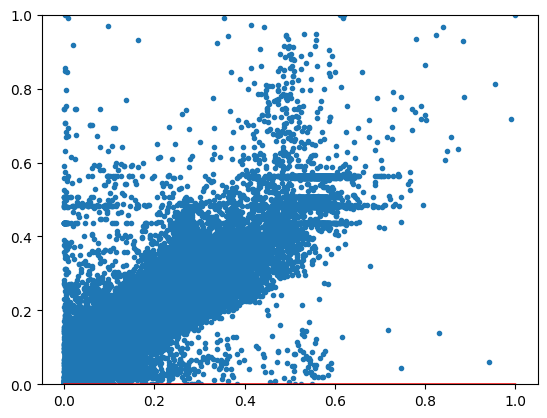

In [ ]:
# Distance run

plt.scatter(xTrain.to_numpy()[:, 1], yTrain, marker=".")
# [classifier.getValue(x) for x in xTrain.to_numpy()]
# plt.plot(xTrain.to_numpy()[:, 1], [classifier.getValue(x) for x in xTrain.to_numpy()], color="red")
plt.ylim([0,np.max(yTrain.to_numpy())])
a = np.linspace(0, np.max(xTrain.to_numpy()[:, 1]), int(np.max(xTrain.to_numpy()[:, 1]) / 100))

In [ ]:
!pip install geopy

['MDR', 'Patahi', 'Purba Champaran', 'Bihar', 'India']
